<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/delta_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount you Google drive to access the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/HumanData/utils')

In [3]:
!pip install librosa pydub snntorch tqdm matplotlib torchinfo

In [24]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary
from snntorch import surrogate, functional

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time
import itertools
import random
import json
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
from preprocessing import SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, DURATION
from preprocessing import (
    load_audio_file,
    naa,
    preprocess_audio,
    batch_logmel,
    pad_to_multiple_of,
    preprocess_dataset
)

from spike_encoding import (
    DeltaAudioDataset,
    ThresholdAdaptiveDataset,
    StepForwardDataset,
    visualize_spike_trains
)

from train_eval import (
    train_fn,
    evaluate_model_comprehensive
)

from models import (
    SNNClassifier,
    C_SNN
)

from performance_analysis import (
    PerformanceProfiler,
    run_performance_evaluation
)

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Save best models

In [29]:
os.makedirs('/content/drive/MyDrive/HumanData/best_models', exist_ok=True)

### Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [8]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [7]:
# Labels ESC-10
class ESCLabels:
    class_names = [
        'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
        'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
    ]
    label_to_index = {label: idx for idx, label in enumerate(class_names)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}


In [8]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100
DURATION = 5.0

In [9]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


# Preprocessing



In [11]:
X_train_tensor, y_train_tensor = preprocess_dataset(X_train, y_train, apply_naa=True, apply_taa=False)
X_val_tensor, y_val_tensor = preprocess_dataset(X_val, y_val, apply_naa=False, apply_taa=False)
X_test_tensor, y_test_tensor = preprocess_dataset(X_test, y_test, apply_naa=False, apply_taa=False)

Log-Mel: 100%|██████████| 80/80 [00:02<00:00, 38.68it/s]


Shape verification

In [12]:
print("X_train:", X_train_tensor.shape, "| y_train:", y_train_tensor.shape)
print("X_val:  ", X_val_tensor.shape, "| y_val:  ", y_val_tensor.shape)
print("X_test: ", X_test_tensor.shape, "| y_test: ", y_test_tensor.shape)

X_train: torch.Size([1200, 128, 900, 1]) | y_train: torch.Size([1200])
X_val:   torch.Size([80, 128, 900, 1]) | y_val:   torch.Size([80])
X_test:  torch.Size([80, 128, 900, 1]) | y_test:  torch.Size([80])


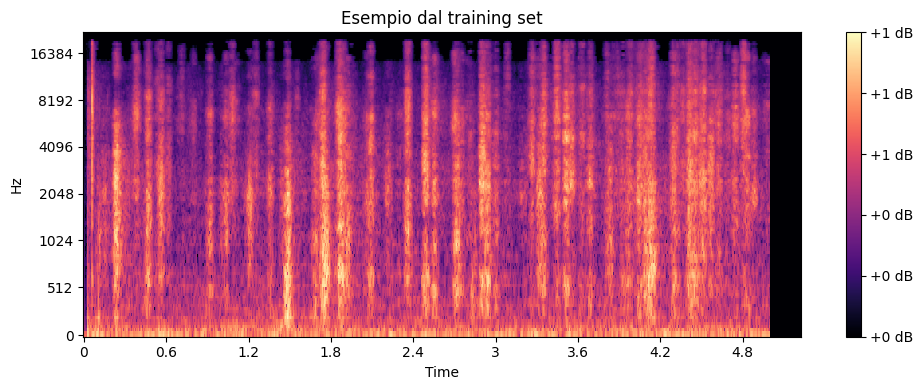

Class: crackling_fire


In [13]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    if isinstance(mel, torch.Tensor):
        mel = mel.squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_tensor[sample_idx], title="Esempio dal training set")
print("Class:", ESCLabels.index_to_label[y_train_tensor[sample_idx].item()])


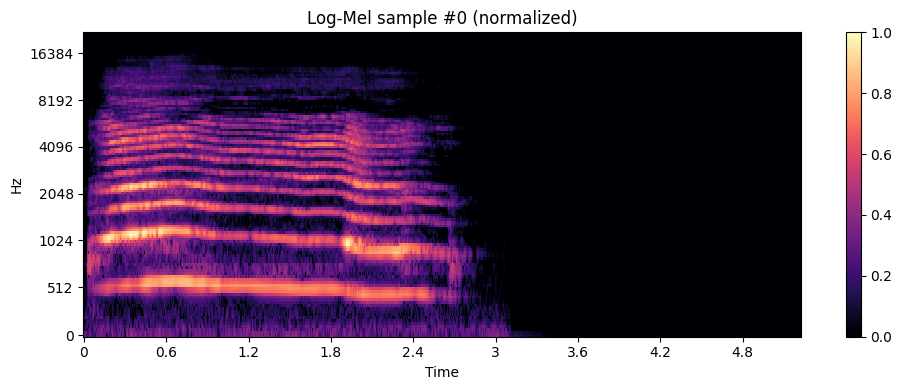

Class: crackling_fire


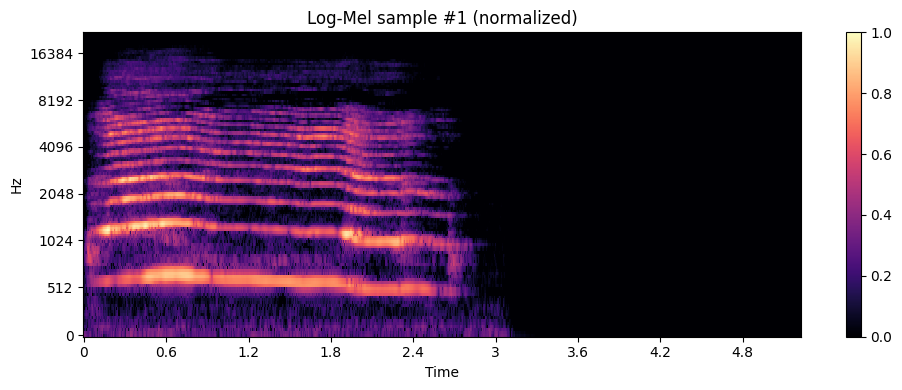

Class: crackling_fire


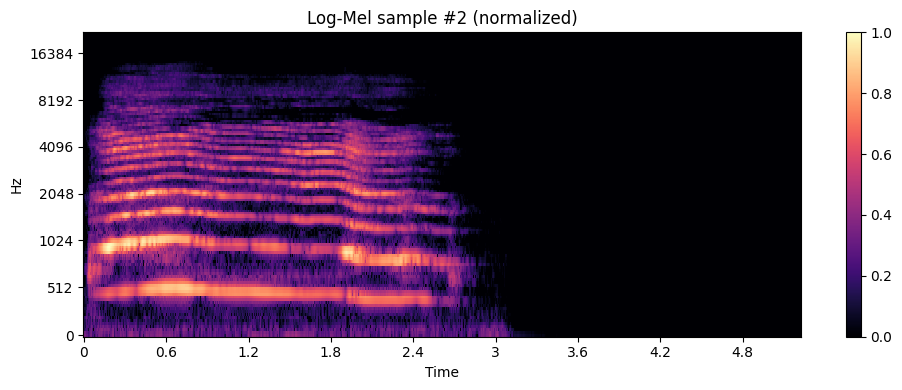

Class: crackling_fire


In [14]:
def show_mel_sample(index):
    mel = X_train_tensor[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels.index_to_label[y_train_tensor[index].item()])

for i in range(3):
    show_mel_sample(i)

#Parameters for training:

In [15]:
patience = 30
num_epochs = 100
hidden_sizes = [128, 128, 128]
num_classes = 10
BATCH_SIZE = 32

# Spike Encoding: Delta Modulation

In [16]:
THRESHOLD = 0.05
TIMESTEPS = 200

In [17]:
delta_train_dataset = DeltaAudioDataset(X_train_tensor, y_train_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_val_dataset = DeltaAudioDataset(X_val_tensor, y_val_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_test_dataset = DeltaAudioDataset(X_test_tensor, y_test_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)

In [18]:
delta_train_loader = DataLoader(delta_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
delta_val_loader = DataLoader(delta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
delta_test_loader = DataLoader(delta_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())

In [19]:
delta_X_batch, delta_y_batch = next(iter(delta_train_loader))
print("DeltaModulation encoding compleated!")

DeltaModulation encoding compleated!


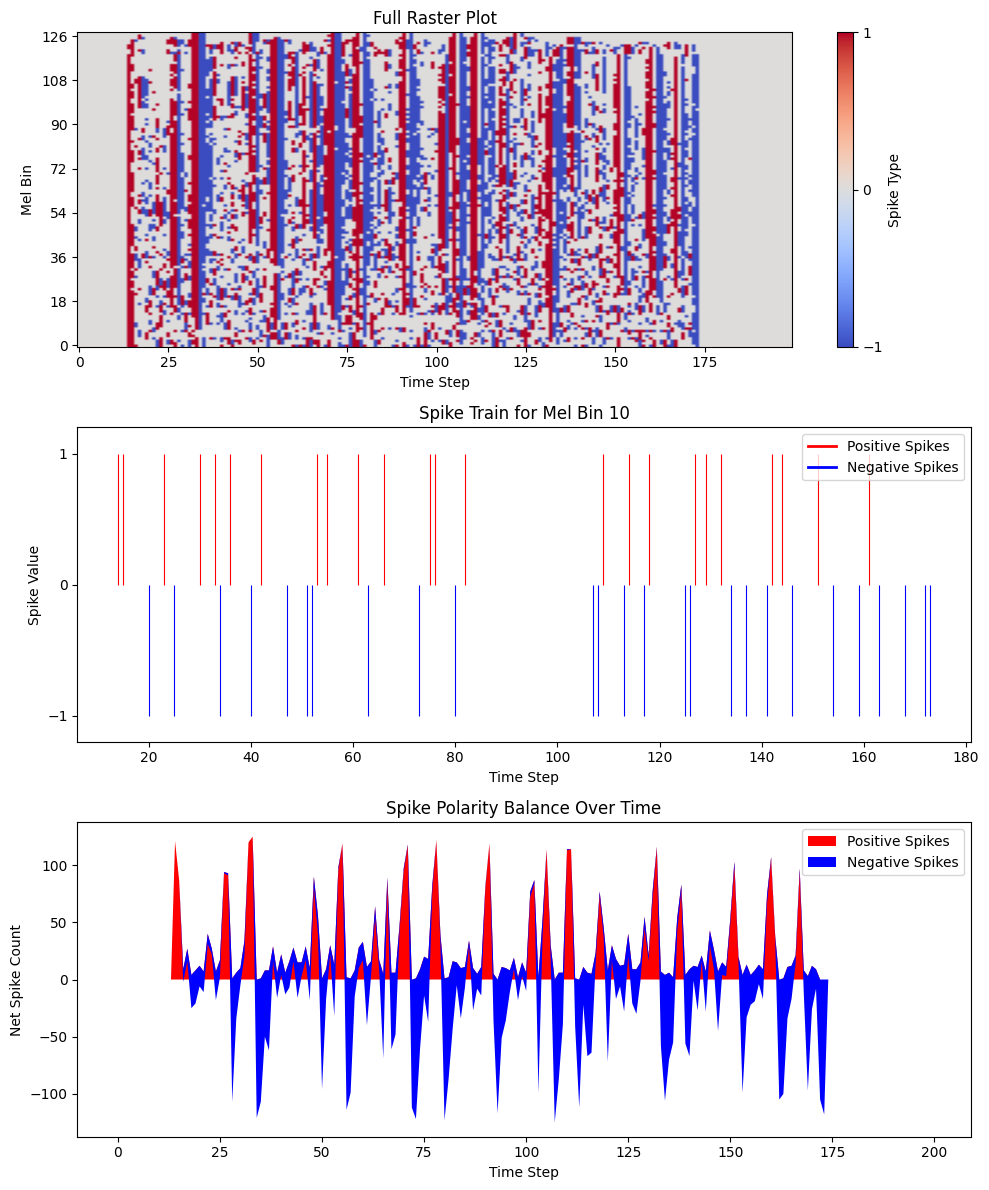

Delta Class: crackling_fire


In [20]:
sample_idx = 10
visualize_spike_trains(delta_X_batch, sample_idx=sample_idx, mel_bin=10)
print(f"Delta Class: {ESCLabels.index_to_label[delta_y_batch[sample_idx].item()]}")

##Delta Modulation: SNN training

In [25]:
delta_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(delta_snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [26]:
optimizer = torch.optim.Adam(delta_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=delta_snn_classifier,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True
)

Epochs:   1%|          | 1/100 [00:39<1:04:42, 39.21s/it]


Epoch 1/100 - 39s - loss: 2.3026 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [01:18<1:03:57, 39.16s/it]


Epoch 2/100 - 39s - loss: 2.3026 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   3%|▎         | 3/100 [01:58<1:03:46, 39.45s/it]


Epoch 3/100 - 39s - loss: 2.2943 - acc: 0.1069 - val_loss: 2.2836 - val_acc: 0.0938



Epochs:   4%|▍         | 4/100 [02:37<1:02:56, 39.34s/it]


Epoch 4/100 - 39s - loss: 2.3202 - acc: 0.1472 - val_loss: 2.3057 - val_acc: 0.0833



Epochs:   5%|▌         | 5/100 [03:15<1:01:39, 38.94s/it]


Epoch 5/100 - 38s - loss: 2.3445 - acc: 0.1472 - val_loss: 2.2608 - val_acc: 0.1250



Epochs:   6%|▌         | 6/100 [03:54<1:00:54, 38.88s/it]


Epoch 6/100 - 38s - loss: 2.4001 - acc: 0.1587 - val_loss: 2.2398 - val_acc: 0.1771



Epochs:   7%|▋         | 7/100 [04:33<1:00:36, 39.10s/it]


Epoch 7/100 - 39s - loss: 2.1664 - acc: 0.2146 - val_loss: 2.1504 - val_acc: 0.2083



Epochs:   8%|▊         | 8/100 [05:12<59:49, 39.01s/it]  


Epoch 8/100 - 38s - loss: 2.0771 - acc: 0.2278 - val_loss: 2.1383 - val_acc: 0.2188



Epochs:   9%|▉         | 9/100 [05:51<59:07, 38.98s/it]


Epoch 9/100 - 38s - loss: 2.1412 - acc: 0.2492 - val_loss: 2.1253 - val_acc: 0.2917



Epochs:  10%|█         | 10/100 [06:29<58:10, 38.78s/it]


Epoch 10/100 - 38s - loss: 2.0273 - acc: 0.2969 - val_loss: 2.8225 - val_acc: 0.3125



Epochs:  11%|█         | 11/100 [07:09<57:56, 39.06s/it]


Epoch 11/100 - 39s - loss: 2.0636 - acc: 0.3018 - val_loss: 2.1863 - val_acc: 0.2500



Epochs:  12%|█▏        | 12/100 [07:48<57:12, 39.01s/it]


Epoch 12/100 - 38s - loss: 2.1519 - acc: 0.2771 - val_loss: 6.7517 - val_acc: 0.1667



Epochs:  13%|█▎        | 13/100 [08:27<56:43, 39.12s/it]


Epoch 13/100 - 39s - loss: 2.3823 - acc: 0.2878 - val_loss: 2.8250 - val_acc: 0.2500



Epochs:  14%|█▍        | 14/100 [09:06<55:40, 38.85s/it]


Epoch 14/100 - 38s - loss: 2.1380 - acc: 0.3289 - val_loss: 1.9056 - val_acc: 0.4167



Epochs:  15%|█▌        | 15/100 [09:45<55:11, 38.96s/it]


Epoch 15/100 - 39s - loss: 1.7348 - acc: 0.3873 - val_loss: 1.5721 - val_acc: 0.4271



Epochs:  16%|█▌        | 16/100 [10:24<54:30, 38.93s/it]


Epoch 16/100 - 38s - loss: 1.7977 - acc: 0.4317 - val_loss: 1.8571 - val_acc: 0.4688



Epochs:  17%|█▋        | 17/100 [11:03<54:05, 39.10s/it]


Epoch 17/100 - 39s - loss: 1.7400 - acc: 0.4704 - val_loss: 1.6491 - val_acc: 0.5521



Epochs:  18%|█▊        | 18/100 [11:42<53:19, 39.01s/it]


Epoch 18/100 - 38s - loss: 1.6149 - acc: 0.4992 - val_loss: 2.0765 - val_acc: 0.5104



Epochs:  19%|█▉        | 19/100 [12:20<52:26, 38.84s/it]


Epoch 19/100 - 38s - loss: 1.4054 - acc: 0.5296 - val_loss: 1.6871 - val_acc: 0.5729



Epochs:  20%|██        | 20/100 [12:59<51:50, 38.88s/it]


Epoch 20/100 - 38s - loss: 1.4762 - acc: 0.5123 - val_loss: 2.0409 - val_acc: 0.4271



Epochs:  21%|██        | 21/100 [13:39<51:24, 39.04s/it]


Epoch 21/100 - 39s - loss: 1.3238 - acc: 0.5387 - val_loss: 1.6173 - val_acc: 0.5833



Epochs:  22%|██▏       | 22/100 [14:17<50:36, 38.93s/it]


Epoch 22/100 - 38s - loss: 1.2656 - acc: 0.5765 - val_loss: 1.7726 - val_acc: 0.5208



Epochs:  23%|██▎       | 23/100 [14:57<50:12, 39.12s/it]


Epoch 23/100 - 39s - loss: 1.1257 - acc: 0.6118 - val_loss: 1.8316 - val_acc: 0.5208



Epochs:  24%|██▍       | 24/100 [15:35<49:02, 38.71s/it]


Epoch 24/100 - 37s - loss: 1.1161 - acc: 0.6127 - val_loss: 1.6965 - val_acc: 0.5417



Epochs:  25%|██▌       | 25/100 [16:14<48:45, 39.00s/it]


Epoch 25/100 - 39s - loss: 1.0109 - acc: 0.6414 - val_loss: 1.4898 - val_acc: 0.5312



Epochs:  26%|██▌       | 26/100 [16:53<48:02, 38.96s/it]


Epoch 26/100 - 38s - loss: 0.9791 - acc: 0.6612 - val_loss: 1.3093 - val_acc: 0.6250



Epochs:  27%|██▋       | 27/100 [17:33<47:35, 39.11s/it]


Epoch 27/100 - 39s - loss: 0.9502 - acc: 0.6817 - val_loss: 1.4854 - val_acc: 0.5729



Epochs:  28%|██▊       | 28/100 [18:11<46:28, 38.73s/it]


Epoch 28/100 - 37s - loss: 0.8769 - acc: 0.7048 - val_loss: 1.6594 - val_acc: 0.5833



Epochs:  29%|██▉       | 29/100 [18:50<45:55, 38.81s/it]


Epoch 29/100 - 38s - loss: 0.8382 - acc: 0.7072 - val_loss: 1.3105 - val_acc: 0.5938



Epochs:  30%|███       | 30/100 [19:28<45:13, 38.76s/it]


Epoch 30/100 - 38s - loss: 0.7992 - acc: 0.7212 - val_loss: 1.4778 - val_acc: 0.5729



Epochs:  31%|███       | 31/100 [20:07<44:41, 38.86s/it]


Epoch 31/100 - 39s - loss: 0.7775 - acc: 0.7319 - val_loss: 1.5000 - val_acc: 0.6458



Epochs:  32%|███▏      | 32/100 [20:45<43:41, 38.55s/it]


Epoch 32/100 - 37s - loss: 0.7141 - acc: 0.7401 - val_loss: 1.4822 - val_acc: 0.6458



Epochs:  33%|███▎      | 33/100 [21:23<42:56, 38.45s/it]


Epoch 33/100 - 38s - loss: 0.6594 - acc: 0.7648 - val_loss: 1.3526 - val_acc: 0.6771



Epochs:  34%|███▍      | 34/100 [22:03<42:33, 38.68s/it]


Epoch 34/100 - 39s - loss: 0.6674 - acc: 0.7590 - val_loss: 1.5186 - val_acc: 0.6354



Epochs:  35%|███▌      | 35/100 [22:41<41:52, 38.66s/it]


Epoch 35/100 - 38s - loss: 0.5963 - acc: 0.7878 - val_loss: 1.4112 - val_acc: 0.6667



Epochs:  36%|███▌      | 36/100 [23:20<41:20, 38.76s/it]


Epoch 36/100 - 38s - loss: 0.5304 - acc: 0.8109 - val_loss: 1.1289 - val_acc: 0.7083



Epochs:  37%|███▋      | 37/100 [23:58<40:19, 38.40s/it]


Epoch 37/100 - 37s - loss: 0.5919 - acc: 0.7936 - val_loss: 1.4083 - val_acc: 0.5833



Epochs:  38%|███▊      | 38/100 [24:37<39:59, 38.71s/it]


Epoch 38/100 - 39s - loss: 0.4685 - acc: 0.8339 - val_loss: 1.2397 - val_acc: 0.6562



Epochs:  39%|███▉      | 39/100 [25:16<39:15, 38.62s/it]


Epoch 39/100 - 38s - loss: 0.4621 - acc: 0.8174 - val_loss: 1.1891 - val_acc: 0.6667



Epochs:  40%|████      | 40/100 [25:55<38:42, 38.72s/it]


Epoch 40/100 - 38s - loss: 0.5000 - acc: 0.8339 - val_loss: 1.4326 - val_acc: 0.7292



Epochs:  41%|████      | 41/100 [26:32<37:39, 38.29s/it]


Epoch 41/100 - 37s - loss: 0.4284 - acc: 0.8487 - val_loss: 1.2855 - val_acc: 0.6562



Epochs:  42%|████▏     | 42/100 [27:11<37:17, 38.58s/it]


Epoch 42/100 - 39s - loss: 0.4213 - acc: 0.8421 - val_loss: 1.3374 - val_acc: 0.6875



Epochs:  43%|████▎     | 43/100 [27:50<36:37, 38.56s/it]


Epoch 43/100 - 38s - loss: 0.3708 - acc: 0.8643 - val_loss: 1.0682 - val_acc: 0.6875



Epochs:  44%|████▍     | 44/100 [28:29<36:07, 38.71s/it]


Epoch 44/100 - 39s - loss: 0.3735 - acc: 0.8651 - val_loss: 1.4163 - val_acc: 0.6562



Epochs:  45%|████▌     | 45/100 [29:06<35:07, 38.32s/it]


Epoch 45/100 - 37s - loss: 0.3247 - acc: 0.8799 - val_loss: 1.1510 - val_acc: 0.7188



Epochs:  46%|████▌     | 46/100 [29:46<34:51, 38.73s/it]


Epoch 46/100 - 39s - loss: 0.3311 - acc: 0.8766 - val_loss: 1.3038 - val_acc: 0.6146



Epochs:  47%|████▋     | 47/100 [30:25<34:13, 38.74s/it]


Epoch 47/100 - 38s - loss: 0.3697 - acc: 0.8586 - val_loss: 1.1020 - val_acc: 0.7083



Epochs:  48%|████▊     | 48/100 [31:04<33:45, 38.95s/it]


Epoch 48/100 - 39s - loss: 0.3497 - acc: 0.8750 - val_loss: 1.4334 - val_acc: 0.6354



Epochs:  49%|████▉     | 49/100 [31:42<32:53, 38.70s/it]


Epoch 49/100 - 38s - loss: 0.3209 - acc: 0.8956 - val_loss: 1.6824 - val_acc: 0.6042



Epochs:  50%|█████     | 50/100 [32:21<32:22, 38.86s/it]


Epoch 50/100 - 39s - loss: 0.2999 - acc: 0.8873 - val_loss: 1.1568 - val_acc: 0.6562



Epochs:  51%|█████     | 51/100 [33:00<31:43, 38.85s/it]


Epoch 51/100 - 38s - loss: 0.3123 - acc: 0.8783 - val_loss: 1.0135 - val_acc: 0.6771



Epochs:  52%|█████▏    | 52/100 [33:39<31:07, 38.90s/it]


Epoch 52/100 - 39s - loss: 0.3013 - acc: 0.8923 - val_loss: 1.2621 - val_acc: 0.6875



Epochs:  53%|█████▎    | 53/100 [34:18<30:20, 38.72s/it]


Epoch 53/100 - 38s - loss: 0.3017 - acc: 0.8791 - val_loss: 1.2862 - val_acc: 0.6771



Epochs:  54%|█████▍    | 54/100 [34:56<29:38, 38.67s/it]


Epoch 54/100 - 38s - loss: 0.2212 - acc: 0.9186 - val_loss: 1.0978 - val_acc: 0.8021



Epochs:  55%|█████▌    | 55/100 [35:35<28:59, 38.65s/it]


Epoch 55/100 - 38s - loss: 0.2414 - acc: 0.9137 - val_loss: 1.5430 - val_acc: 0.6250



Epochs:  56%|█████▌    | 56/100 [36:14<28:31, 38.89s/it]


Epoch 56/100 - 39s - loss: 0.2548 - acc: 0.9054 - val_loss: 1.4440 - val_acc: 0.6771



Epochs:  57%|█████▋    | 57/100 [36:54<28:06, 39.22s/it]


Epoch 57/100 - 39s - loss: 0.1983 - acc: 0.9326 - val_loss: 1.4118 - val_acc: 0.6875



Epochs:  58%|█████▊    | 58/100 [37:36<27:58, 39.96s/it]


Epoch 58/100 - 41s - loss: 0.2036 - acc: 0.9235 - val_loss: 1.3116 - val_acc: 0.6667



Epochs:  59%|█████▉    | 59/100 [38:14<26:53, 39.34s/it]


Epoch 59/100 - 37s - loss: 0.2105 - acc: 0.9137 - val_loss: 1.8291 - val_acc: 0.6458



Epochs:  60%|██████    | 60/100 [39:01<27:47, 41.68s/it]


Epoch 60/100 - 47s - loss: 0.1978 - acc: 0.9252 - val_loss: 1.2637 - val_acc: 0.7396



Epochs:  61%|██████    | 61/100 [39:41<26:51, 41.32s/it]


Epoch 61/100 - 40s - loss: 0.1825 - acc: 0.9260 - val_loss: 1.1422 - val_acc: 0.7083



Epochs:  62%|██████▏   | 62/100 [40:20<25:45, 40.66s/it]


Epoch 62/100 - 39s - loss: 0.2350 - acc: 0.9194 - val_loss: 1.8636 - val_acc: 0.6146



Epochs:  63%|██████▎   | 63/100 [41:06<26:01, 42.20s/it]


Epoch 63/100 - 45s - loss: 0.2510 - acc: 0.9128 - val_loss: 1.6142 - val_acc: 0.6354



Epochs:  64%|██████▍   | 64/100 [41:49<25:23, 42.33s/it]


Epoch 64/100 - 42s - loss: 0.3305 - acc: 0.8898 - val_loss: 1.6232 - val_acc: 0.6562



Epochs:  65%|██████▌   | 65/100 [42:27<24:01, 41.19s/it]


Epoch 65/100 - 38s - loss: 0.2349 - acc: 0.9137 - val_loss: 1.4028 - val_acc: 0.6667



Epochs:  66%|██████▌   | 66/100 [43:09<23:25, 41.34s/it]


Epoch 66/100 - 41s - loss: 0.2187 - acc: 0.9178 - val_loss: 1.6797 - val_acc: 0.6771



Epochs:  67%|██████▋   | 67/100 [43:48<22:25, 40.76s/it]


Epoch 67/100 - 39s - loss: 0.1752 - acc: 0.9334 - val_loss: 1.4116 - val_acc: 0.7604



Epochs:  68%|██████▊   | 68/100 [44:29<21:46, 40.82s/it]


Epoch 68/100 - 40s - loss: 0.2091 - acc: 0.9252 - val_loss: 1.5783 - val_acc: 0.6250



Epochs:  69%|██████▉   | 69/100 [45:09<20:49, 40.30s/it]


Epoch 69/100 - 39s - loss: 0.2238 - acc: 0.9186 - val_loss: 1.3348 - val_acc: 0.7396



Epochs:  70%|███████   | 70/100 [45:48<20:00, 40.02s/it]


Epoch 70/100 - 39s - loss: 0.2978 - acc: 0.9104 - val_loss: 1.3000 - val_acc: 0.6562



Epochs:  71%|███████   | 71/100 [46:27<19:09, 39.62s/it]


Epoch 71/100 - 38s - loss: 0.2960 - acc: 0.9021 - val_loss: 1.3142 - val_acc: 0.6771



Epochs:  72%|███████▏  | 72/100 [47:06<18:28, 39.60s/it]


Epoch 72/100 - 39s - loss: 0.3054 - acc: 0.8857 - val_loss: 1.3863 - val_acc: 0.7292



Epochs:  73%|███████▎  | 73/100 [47:45<17:44, 39.41s/it]


Epoch 73/100 - 38s - loss: 0.1774 - acc: 0.9309 - val_loss: 1.3920 - val_acc: 0.6562



Epochs:  74%|███████▍  | 74/100 [48:24<17:04, 39.41s/it]


Epoch 74/100 - 39s - loss: 0.1715 - acc: 0.9465 - val_loss: 1.6938 - val_acc: 0.6042



Epochs:  75%|███████▌  | 75/100 [49:03<16:17, 39.10s/it]


Epoch 75/100 - 38s - loss: 0.2644 - acc: 0.9137 - val_loss: 1.1429 - val_acc: 0.7188



Epochs:  76%|███████▌  | 76/100 [49:42<15:38, 39.11s/it]


Epoch 76/100 - 39s - loss: 0.1387 - acc: 0.9433 - val_loss: 1.6405 - val_acc: 0.6875



Epochs:  77%|███████▋  | 77/100 [50:21<14:59, 39.13s/it]


Epoch 77/100 - 39s - loss: 0.1410 - acc: 0.9482 - val_loss: 1.1445 - val_acc: 0.7396



Epochs:  78%|███████▊  | 78/100 [51:01<14:26, 39.37s/it]


Epoch 78/100 - 39s - loss: 0.1574 - acc: 0.9474 - val_loss: 1.0145 - val_acc: 0.7188



Epochs:  79%|███████▉  | 79/100 [51:40<13:45, 39.32s/it]


Epoch 79/100 - 39s - loss: 0.1277 - acc: 0.9474 - val_loss: 1.3096 - val_acc: 0.7188



Epochs:  80%|████████  | 80/100 [52:19<13:00, 39.02s/it]


Epoch 80/100 - 38s - loss: 0.1290 - acc: 0.9531 - val_loss: 1.4444 - val_acc: 0.7292



Epochs:  80%|████████  | 80/100 [52:58<13:14, 39.73s/it]

Early stopping triggered


In [34]:
torch.save(delta_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/delta_modulation/delta_snn.pth')

##Delta Modulation: SNN evaluation

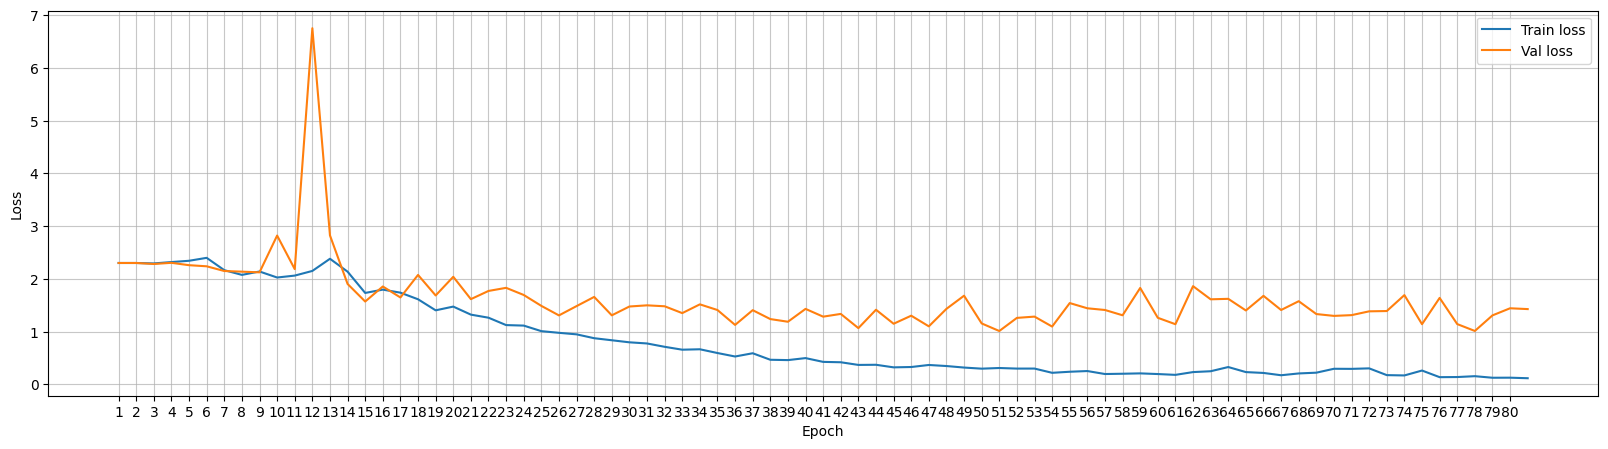

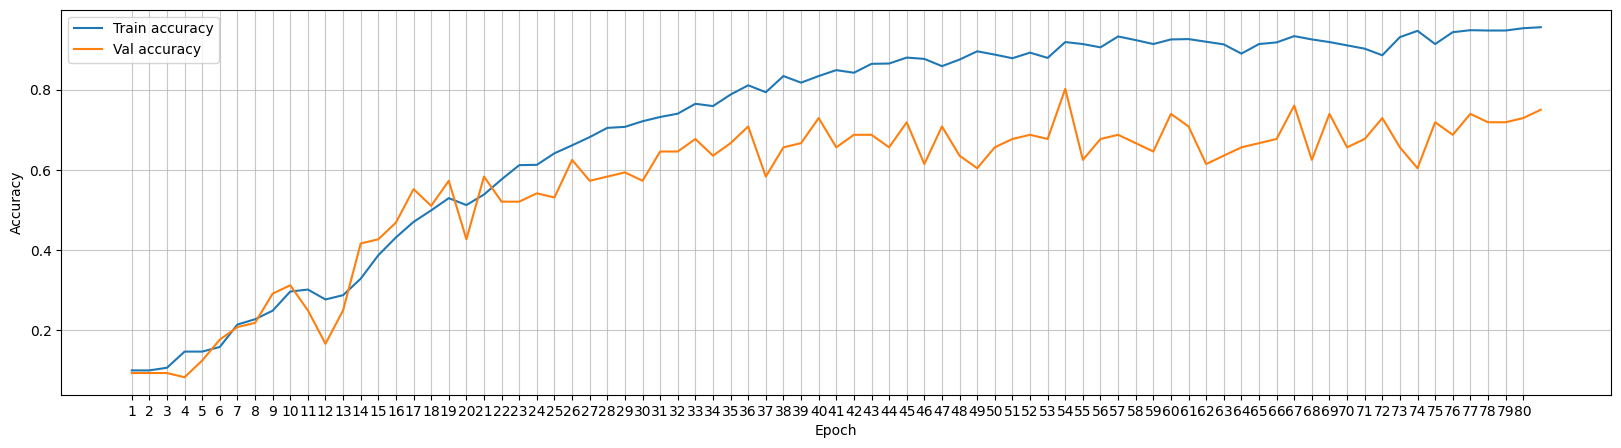

In [27]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6625 (66.25%)

MACRO AVERAGES:
  F1-Score   : 0.6493
  Precision  : 0.6749
  Recall     : 0.6625

WEIGHTED AVERAGES:
  F1-Score   : 0.6493
  Precision  : 0.6749
  Recall     : 0.6625

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.5833   0.4375     0.8750  
clock_tick      0.7143   0.8333     0.6250  
crackling_fire  0.5882   0.5556     0.6250  
crying_baby     0.9412   0.8889     1.0000  
dog             0.7778   0.7000     0.8750  
helicopter      0.7059   0.6667     0.7500  
rain            0.4286   0.5000     0.3750  
rooster         0.8571   1.0000     0.7500  
sea_waves       0.1818   0.3333     0.1250  
sneezing        0.7143   0.8333     0.6250  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.4375    0.8750    0.5833 

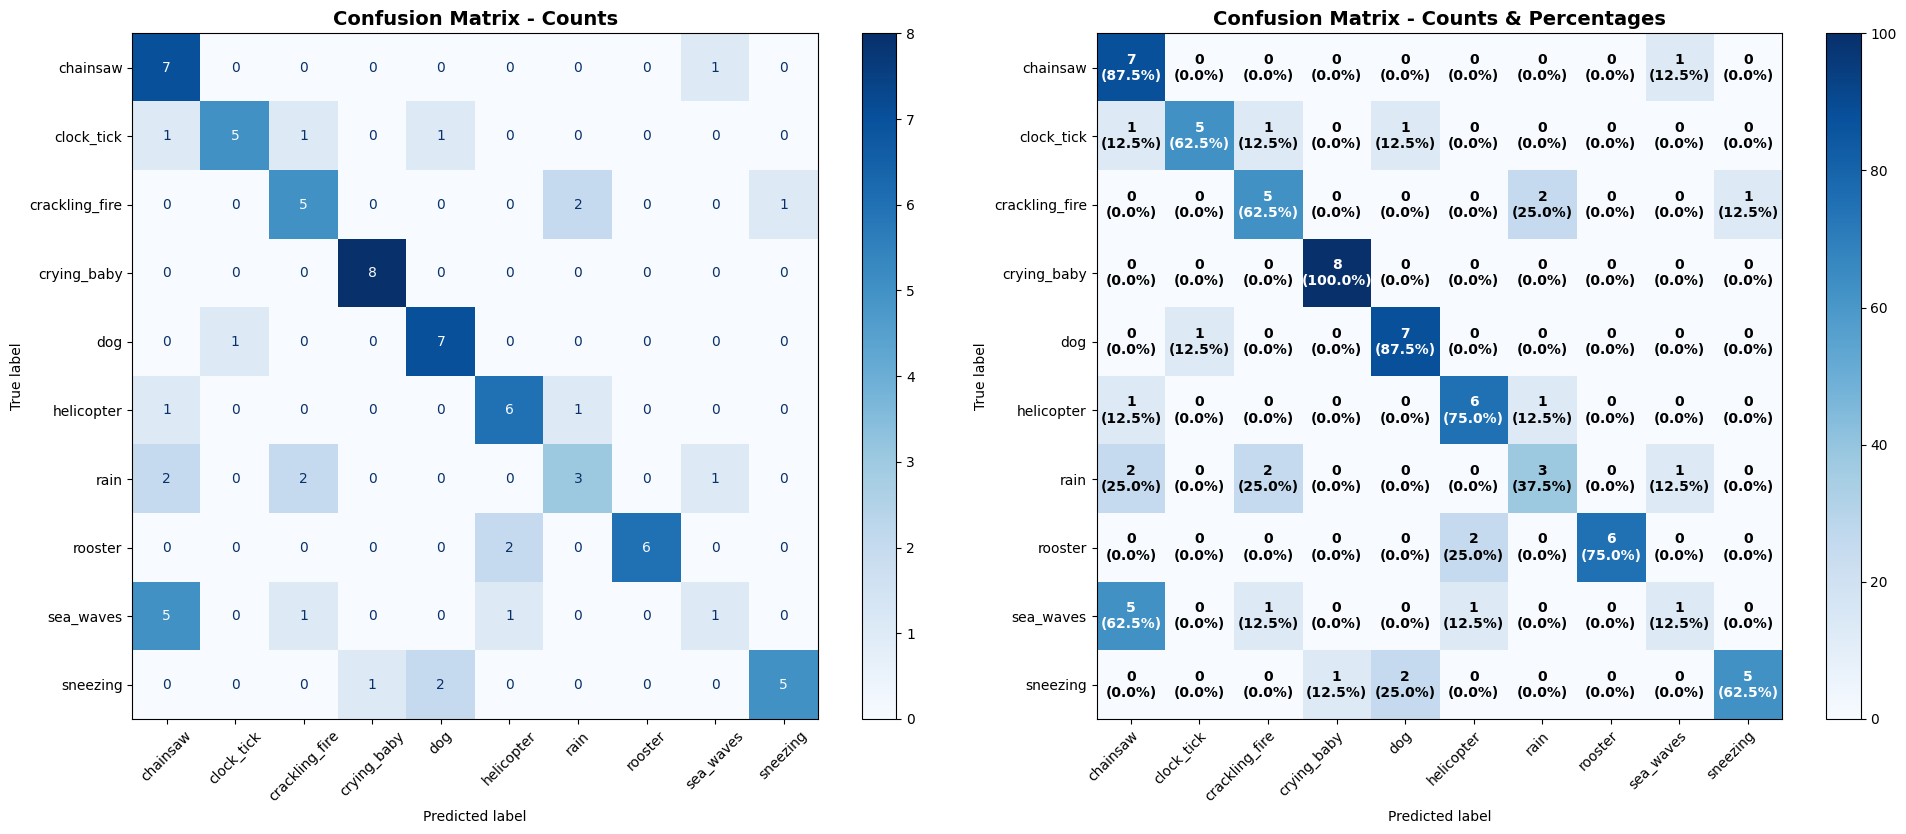


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        7        8        87.50     %
clock_tick      5        8        62.50     %
crackling_fire  5        8        62.50     %
crying_baby     8        8        100.00    %
dog             7        8        87.50     %
helicopter      6        8        75.00     %
rain            3        8        37.50     %
rooster         6        8        75.00     %
sea_waves       1        8        12.50     %
sneezing        5        8        62.50     %


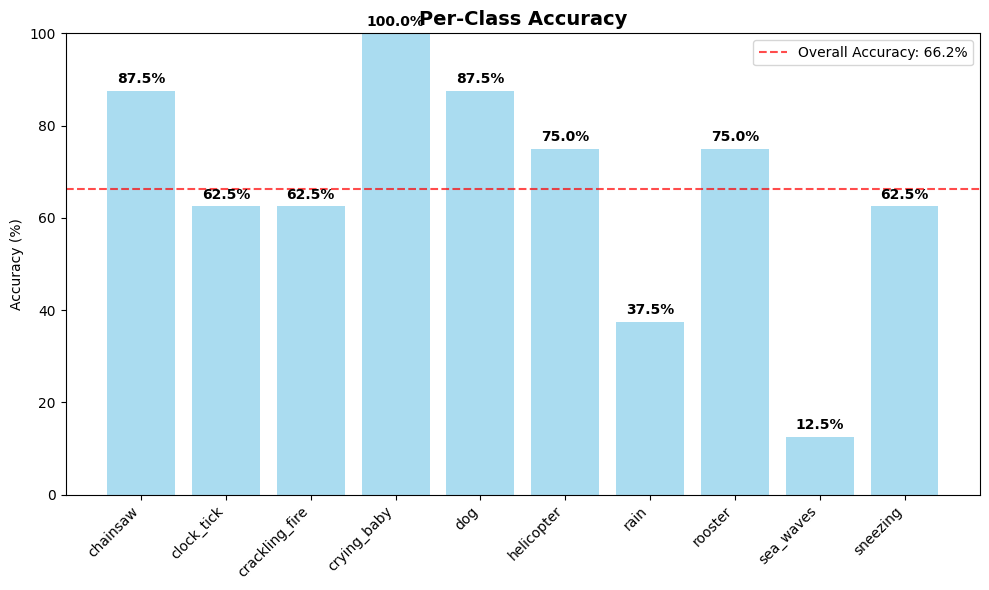

In [28]:
results_snn_delta = evaluate_model_comprehensive(delta_snn_classifier, delta_test_loader, ESCLabels.class_names, device)

##Delta Modulation: SCNN training

In [35]:
delta_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(delta_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 8, 128]              24
├─Leaky: 1-2                             [32, 8, 128]              2
├─MaxPool1d: 1-3                         [32, 8, 64]               --
├─Dropout: 1-4                           [32, 512]                 --
├─Linear: 1-5                            [32, 10]                  5,120
├─Leaky: 1-6                             [32, 10]                  2
Total params: 5,148
Trainable params: 5,148
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.26
Input size (MB): 0.02
Forward/backward pass size (MB): 0.53
Params size (MB): 0.02
Estimated Total Size (MB): 0.57

In [37]:
optimizer = torch.optim.Adam(delta_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=delta_c_snn_model,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Epochs:   1%|          | 1/100 [00:34<56:39, 34.34s/it]


Epoch 1/100 - 34s - loss: 2.4798 - acc: 0.1406 - val_loss: 2.2888 - val_acc: 0.1667



Epochs:   2%|▏         | 2/100 [01:11<58:51, 36.03s/it]


Epoch 2/100 - 37s - loss: 2.2218 - acc: 0.1735 - val_loss: 2.3208 - val_acc: 0.1250



Epochs:   3%|▎         | 3/100 [01:55<1:03:57, 39.57s/it]


Epoch 3/100 - 43s - loss: 2.1559 - acc: 0.2023 - val_loss: 2.2294 - val_acc: 0.2188



Epochs:   4%|▍         | 4/100 [02:32<1:01:45, 38.60s/it]


Epoch 4/100 - 37s - loss: 2.0994 - acc: 0.2311 - val_loss: 2.2213 - val_acc: 0.2188



Epochs:   5%|▌         | 5/100 [03:11<1:01:38, 38.94s/it]


Epoch 5/100 - 39s - loss: 2.0324 - acc: 0.2467 - val_loss: 2.2296 - val_acc: 0.1667



Epochs:   6%|▌         | 6/100 [03:45<57:54, 36.96s/it]  


Epoch 6/100 - 33s - loss: 2.0045 - acc: 0.2410 - val_loss: 2.1802 - val_acc: 0.1979



Epochs:   7%|▋         | 7/100 [04:17<55:13, 35.63s/it]


Epoch 7/100 - 32s - loss: 1.9360 - acc: 0.2681 - val_loss: 2.2005 - val_acc: 0.1979



Epochs:   8%|▊         | 8/100 [04:51<53:28, 34.87s/it]


Epoch 8/100 - 33s - loss: 1.8603 - acc: 0.2985 - val_loss: 2.0672 - val_acc: 0.2917



Epochs:   9%|▉         | 9/100 [05:26<52:58, 34.92s/it]


Epoch 9/100 - 35s - loss: 1.6993 - acc: 0.3701 - val_loss: 1.8777 - val_acc: 0.3125



Epochs:  10%|█         | 10/100 [05:59<51:28, 34.32s/it]


Epoch 10/100 - 32s - loss: 1.4609 - acc: 0.4375 - val_loss: 1.6307 - val_acc: 0.4167



Epochs:  11%|█         | 11/100 [06:33<50:43, 34.20s/it]


Epoch 11/100 - 33s - loss: 1.3000 - acc: 0.4844 - val_loss: 1.4475 - val_acc: 0.5000



Epochs:  12%|█▏        | 12/100 [07:05<49:22, 33.67s/it]


Epoch 12/100 - 32s - loss: 1.2238 - acc: 0.5164 - val_loss: 1.4891 - val_acc: 0.4896



Epochs:  13%|█▎        | 13/100 [07:39<48:52, 33.71s/it]


Epoch 13/100 - 33s - loss: 1.1849 - acc: 0.5090 - val_loss: 1.4476 - val_acc: 0.4792



Epochs:  14%|█▍        | 14/100 [08:12<48:14, 33.66s/it]


Epoch 14/100 - 33s - loss: 1.0861 - acc: 0.5567 - val_loss: 1.3665 - val_acc: 0.4583



Epochs:  15%|█▌        | 15/100 [08:46<47:32, 33.56s/it]


Epoch 15/100 - 33s - loss: 1.0292 - acc: 0.5913 - val_loss: 1.2516 - val_acc: 0.5312



Epochs:  16%|█▌        | 16/100 [09:21<47:35, 34.00s/it]


Epoch 16/100 - 35s - loss: 1.0027 - acc: 0.5831 - val_loss: 1.2585 - val_acc: 0.5521



Epochs:  17%|█▋        | 17/100 [09:54<46:36, 33.70s/it]


Epoch 17/100 - 32s - loss: 0.9557 - acc: 0.6020 - val_loss: 1.2276 - val_acc: 0.5312



Epochs:  18%|█▊        | 18/100 [10:27<45:47, 33.50s/it]


Epoch 18/100 - 33s - loss: 0.8963 - acc: 0.6447 - val_loss: 1.1814 - val_acc: 0.5625



Epochs:  19%|█▉        | 19/100 [11:00<45:04, 33.39s/it]


Epoch 19/100 - 33s - loss: 0.8887 - acc: 0.6373 - val_loss: 1.2047 - val_acc: 0.6146



Epochs:  20%|██        | 20/100 [11:33<44:11, 33.15s/it]


Epoch 20/100 - 32s - loss: 0.8435 - acc: 0.6497 - val_loss: 1.2289 - val_acc: 0.5833



Epochs:  21%|██        | 21/100 [12:06<43:52, 33.32s/it]


Epoch 21/100 - 33s - loss: 0.8166 - acc: 0.6719 - val_loss: 1.1296 - val_acc: 0.5729



Epochs:  22%|██▏       | 22/100 [12:39<43:08, 33.19s/it]


Epoch 22/100 - 32s - loss: 0.7868 - acc: 0.6941 - val_loss: 1.0852 - val_acc: 0.6250



Epochs:  23%|██▎       | 23/100 [13:13<42:42, 33.28s/it]


Epoch 23/100 - 33s - loss: 0.7582 - acc: 0.7007 - val_loss: 1.0776 - val_acc: 0.6250



Epochs:  24%|██▍       | 24/100 [13:46<42:17, 33.39s/it]


Epoch 24/100 - 33s - loss: 0.7293 - acc: 0.7204 - val_loss: 1.0111 - val_acc: 0.6562



Epochs:  25%|██▌       | 25/100 [14:19<41:23, 33.12s/it]


Epoch 25/100 - 32s - loss: 0.7101 - acc: 0.7237 - val_loss: 1.0034 - val_acc: 0.6250



Epochs:  26%|██▌       | 26/100 [14:52<40:42, 33.00s/it]


Epoch 26/100 - 32s - loss: 0.6858 - acc: 0.7377 - val_loss: 0.9718 - val_acc: 0.6042



Epochs:  27%|██▋       | 27/100 [15:25<40:18, 33.13s/it]


Epoch 27/100 - 33s - loss: 0.6706 - acc: 0.7360 - val_loss: 0.9495 - val_acc: 0.6667



Epochs:  28%|██▊       | 28/100 [15:57<39:32, 32.95s/it]


Epoch 28/100 - 32s - loss: 0.6329 - acc: 0.7656 - val_loss: 0.9688 - val_acc: 0.6667



Epochs:  29%|██▉       | 29/100 [16:31<39:04, 33.02s/it]


Epoch 29/100 - 33s - loss: 0.6140 - acc: 0.7656 - val_loss: 0.9281 - val_acc: 0.6771



Epochs:  30%|███       | 30/100 [17:04<38:43, 33.19s/it]


Epoch 30/100 - 33s - loss: 0.6050 - acc: 0.7755 - val_loss: 0.9016 - val_acc: 0.6458



Epochs:  31%|███       | 31/100 [17:37<37:51, 32.92s/it]


Epoch 31/100 - 32s - loss: 0.5911 - acc: 0.7755 - val_loss: 0.9767 - val_acc: 0.6458



Epochs:  32%|███▏      | 32/100 [18:10<37:25, 33.03s/it]


Epoch 32/100 - 33s - loss: 0.5758 - acc: 0.7738 - val_loss: 0.9388 - val_acc: 0.6667



Epochs:  33%|███▎      | 33/100 [18:42<36:43, 32.89s/it]


Epoch 33/100 - 32s - loss: 0.5443 - acc: 0.8010 - val_loss: 0.9737 - val_acc: 0.6250



Epochs:  34%|███▍      | 34/100 [19:15<36:03, 32.78s/it]


Epoch 34/100 - 32s - loss: 0.5396 - acc: 0.7985 - val_loss: 0.9916 - val_acc: 0.6354



Epochs:  35%|███▌      | 35/100 [19:48<35:40, 32.93s/it]


Epoch 35/100 - 33s - loss: 0.5403 - acc: 0.7985 - val_loss: 1.0248 - val_acc: 0.6354



Epochs:  36%|███▌      | 36/100 [20:21<35:05, 32.91s/it]


Epoch 36/100 - 32s - loss: 0.5366 - acc: 0.7985 - val_loss: 1.0353 - val_acc: 0.6562



Epochs:  37%|███▋      | 37/100 [20:54<34:38, 32.99s/it]


Epoch 37/100 - 33s - loss: 0.5009 - acc: 0.8084 - val_loss: 0.9435 - val_acc: 0.6354



Epochs:  38%|███▊      | 38/100 [21:29<34:36, 33.49s/it]


Epoch 38/100 - 34s - loss: 0.4768 - acc: 0.8150 - val_loss: 0.9363 - val_acc: 0.6771



Epochs:  39%|███▉      | 39/100 [22:02<33:51, 33.30s/it]


Epoch 39/100 - 32s - loss: 0.4517 - acc: 0.8207 - val_loss: 0.9129 - val_acc: 0.6562



Epochs:  40%|████      | 40/100 [22:35<33:18, 33.30s/it]


Epoch 40/100 - 33s - loss: 0.4513 - acc: 0.8224 - val_loss: 0.9566 - val_acc: 0.6458



Epochs:  41%|████      | 41/100 [23:09<32:50, 33.40s/it]


Epoch 41/100 - 33s - loss: 0.4544 - acc: 0.8281 - val_loss: 0.9910 - val_acc: 0.6562



Epochs:  42%|████▏     | 42/100 [23:42<32:07, 33.24s/it]


Epoch 42/100 - 32s - loss: 0.4403 - acc: 0.8347 - val_loss: 0.9156 - val_acc: 0.7083



Epochs:  43%|████▎     | 43/100 [24:16<32:00, 33.70s/it]


Epoch 43/100 - 34s - loss: 0.4178 - acc: 0.8470 - val_loss: 0.9928 - val_acc: 0.6667



Epochs:  44%|████▍     | 44/100 [24:49<31:12, 33.43s/it]


Epoch 44/100 - 32s - loss: 0.4228 - acc: 0.8273 - val_loss: 0.9153 - val_acc: 0.6771



Epochs:  45%|████▌     | 45/100 [25:23<30:42, 33.50s/it]


Epoch 45/100 - 33s - loss: 0.4106 - acc: 0.8512 - val_loss: 0.9470 - val_acc: 0.6667



Epochs:  46%|████▌     | 46/100 [25:57<30:17, 33.66s/it]


Epoch 46/100 - 34s - loss: 0.4015 - acc: 0.8438 - val_loss: 0.9218 - val_acc: 0.6771



Epochs:  47%|████▋     | 47/100 [26:30<29:32, 33.45s/it]


Epoch 47/100 - 32s - loss: 0.4083 - acc: 0.8405 - val_loss: 0.9297 - val_acc: 0.7708



Epochs:  48%|████▊     | 48/100 [27:04<29:08, 33.63s/it]


Epoch 48/100 - 34s - loss: 0.3959 - acc: 0.8520 - val_loss: 0.9350 - val_acc: 0.7083



Epochs:  49%|████▉     | 49/100 [27:37<28:22, 33.38s/it]


Epoch 49/100 - 32s - loss: 0.3824 - acc: 0.8528 - val_loss: 0.9204 - val_acc: 0.7396



Epochs:  50%|█████     | 50/100 [28:10<27:48, 33.37s/it]


Epoch 50/100 - 33s - loss: 0.3950 - acc: 0.8446 - val_loss: 0.9798 - val_acc: 0.7396



Epochs:  51%|█████     | 51/100 [28:44<27:27, 33.63s/it]


Epoch 51/100 - 34s - loss: 0.3731 - acc: 0.8668 - val_loss: 0.9439 - val_acc: 0.7500



Epochs:  52%|█████▏    | 52/100 [29:17<26:45, 33.45s/it]


Epoch 52/100 - 33s - loss: 0.3911 - acc: 0.8577 - val_loss: 1.0100 - val_acc: 0.7396



Epochs:  53%|█████▎    | 53/100 [29:51<26:13, 33.47s/it]


Epoch 53/100 - 33s - loss: 0.3688 - acc: 0.8627 - val_loss: 0.8978 - val_acc: 0.7500



Epochs:  54%|█████▍    | 54/100 [30:24<25:39, 33.47s/it]


Epoch 54/100 - 33s - loss: 0.3629 - acc: 0.8684 - val_loss: 0.9901 - val_acc: 0.7083



Epochs:  55%|█████▌    | 55/100 [30:57<24:53, 33.20s/it]


Epoch 55/100 - 32s - loss: 0.3573 - acc: 0.8594 - val_loss: 0.9829 - val_acc: 0.7083



Epochs:  56%|█████▌    | 56/100 [31:31<24:33, 33.48s/it]


Epoch 56/100 - 34s - loss: 0.3557 - acc: 0.8602 - val_loss: 1.0024 - val_acc: 0.7188



Epochs:  57%|█████▋    | 57/100 [32:04<24:00, 33.49s/it]


Epoch 57/100 - 33s - loss: 0.3606 - acc: 0.8586 - val_loss: 1.0369 - val_acc: 0.7292



Epochs:  58%|█████▊    | 58/100 [32:38<23:27, 33.52s/it]


Epoch 58/100 - 33s - loss: 0.3675 - acc: 0.8520 - val_loss: 0.9488 - val_acc: 0.7083



Epochs:  59%|█████▉    | 59/100 [33:13<23:09, 33.89s/it]


Epoch 59/100 - 34s - loss: 0.3614 - acc: 0.8627 - val_loss: 0.9621 - val_acc: 0.7188



Epochs:  60%|██████    | 60/100 [33:47<22:39, 33.99s/it]


Epoch 60/100 - 34s - loss: 0.3345 - acc: 0.8717 - val_loss: 1.0395 - val_acc: 0.7396



Epochs:  61%|██████    | 61/100 [34:22<22:22, 34.43s/it]


Epoch 61/100 - 35s - loss: 0.3238 - acc: 0.8783 - val_loss: 1.0159 - val_acc: 0.7188



Epochs:  62%|██████▏   | 62/100 [34:56<21:39, 34.19s/it]


Epoch 62/100 - 33s - loss: 0.3275 - acc: 0.8783 - val_loss: 1.0627 - val_acc: 0.7292



Epochs:  63%|██████▎   | 63/100 [35:32<21:18, 34.56s/it]


Epoch 63/100 - 35s - loss: 0.3299 - acc: 0.8783 - val_loss: 0.9524 - val_acc: 0.7188



Epochs:  64%|██████▍   | 64/100 [36:05<20:33, 34.26s/it]


Epoch 64/100 - 33s - loss: 0.3260 - acc: 0.8758 - val_loss: 1.0061 - val_acc: 0.7083



Epochs:  65%|██████▌   | 65/100 [36:38<19:45, 33.88s/it]


Epoch 65/100 - 32s - loss: 0.3051 - acc: 0.8931 - val_loss: 0.8939 - val_acc: 0.7292



Epochs:  66%|██████▌   | 66/100 [37:12<19:10, 33.83s/it]


Epoch 66/100 - 33s - loss: 0.3187 - acc: 0.8816 - val_loss: 1.0151 - val_acc: 0.7083



Epochs:  67%|██████▋   | 67/100 [37:45<18:25, 33.51s/it]


Epoch 67/100 - 32s - loss: 0.3065 - acc: 0.8882 - val_loss: 0.9851 - val_acc: 0.6875



Epochs:  68%|██████▊   | 68/100 [38:18<17:53, 33.56s/it]


Epoch 68/100 - 33s - loss: 0.3097 - acc: 0.8816 - val_loss: 0.9688 - val_acc: 0.7396



Epochs:  69%|██████▉   | 69/100 [38:52<17:19, 33.54s/it]


Epoch 69/100 - 33s - loss: 0.3121 - acc: 0.8816 - val_loss: 1.0732 - val_acc: 0.7500



Epochs:  70%|███████   | 70/100 [39:25<16:41, 33.40s/it]


Epoch 70/100 - 33s - loss: 0.2911 - acc: 0.8890 - val_loss: 1.0635 - val_acc: 0.7188



Epochs:  71%|███████   | 71/100 [39:59<16:16, 33.68s/it]


Epoch 71/100 - 34s - loss: 0.2975 - acc: 0.8857 - val_loss: 1.0611 - val_acc: 0.7188



Epochs:  72%|███████▏  | 72/100 [40:32<15:34, 33.37s/it]


Epoch 72/100 - 32s - loss: 0.2977 - acc: 0.8816 - val_loss: 1.1001 - val_acc: 0.7396



Epochs:  73%|███████▎  | 73/100 [41:05<14:55, 33.18s/it]


Epoch 73/100 - 32s - loss: 0.3193 - acc: 0.8849 - val_loss: 1.0364 - val_acc: 0.7396



Epochs:  74%|███████▍  | 74/100 [41:39<14:29, 33.44s/it]


Epoch 74/100 - 34s - loss: 0.2922 - acc: 0.8997 - val_loss: 1.0754 - val_acc: 0.7188



Epochs:  75%|███████▌  | 75/100 [42:11<13:51, 33.25s/it]


Epoch 75/100 - 32s - loss: 0.2831 - acc: 0.8988 - val_loss: 1.0693 - val_acc: 0.7500



Epochs:  76%|███████▌  | 76/100 [42:44<13:16, 33.17s/it]


Epoch 76/100 - 32s - loss: 0.2827 - acc: 0.8988 - val_loss: 1.0978 - val_acc: 0.7708



Epochs:  77%|███████▋  | 77/100 [43:18<12:46, 33.33s/it]


Epoch 77/100 - 33s - loss: 0.2906 - acc: 0.8873 - val_loss: 1.1590 - val_acc: 0.7604



Epochs:  78%|███████▊  | 78/100 [43:51<12:12, 33.31s/it]


Epoch 78/100 - 33s - loss: 0.2838 - acc: 0.8947 - val_loss: 1.0609 - val_acc: 0.6979



Epochs:  79%|███████▉  | 79/100 [44:25<11:40, 33.34s/it]


Epoch 79/100 - 33s - loss: 0.2857 - acc: 0.8906 - val_loss: 1.1093 - val_acc: 0.7604



Epochs:  80%|████████  | 80/100 [44:58<11:06, 33.31s/it]


Epoch 80/100 - 33s - loss: 0.2920 - acc: 0.8923 - val_loss: 1.1689 - val_acc: 0.7604



Epochs:  81%|████████  | 81/100 [45:31<10:29, 33.12s/it]


Epoch 81/100 - 32s - loss: 0.2815 - acc: 0.8906 - val_loss: 1.1696 - val_acc: 0.7708



Epochs:  82%|████████▏ | 82/100 [46:04<09:59, 33.32s/it]


Epoch 82/100 - 33s - loss: 0.2896 - acc: 0.8914 - val_loss: 1.0979 - val_acc: 0.7292



Epochs:  83%|████████▎ | 83/100 [46:37<09:23, 33.14s/it]


Epoch 83/100 - 32s - loss: 0.2809 - acc: 0.9013 - val_loss: 1.0742 - val_acc: 0.7708



Epochs:  84%|████████▍ | 84/100 [47:10<08:48, 33.05s/it]


Epoch 84/100 - 32s - loss: 0.2876 - acc: 0.8997 - val_loss: 1.1404 - val_acc: 0.7500



Epochs:  85%|████████▌ | 85/100 [47:45<08:23, 33.55s/it]


Epoch 85/100 - 34s - loss: 0.2721 - acc: 0.9005 - val_loss: 1.0818 - val_acc: 0.7396



Epochs:  86%|████████▌ | 86/100 [48:17<07:45, 33.28s/it]


Epoch 86/100 - 32s - loss: 0.2840 - acc: 0.8997 - val_loss: 1.1244 - val_acc: 0.7396



Epochs:  87%|████████▋ | 87/100 [48:51<07:15, 33.47s/it]


Epoch 87/100 - 33s - loss: 0.2722 - acc: 0.9054 - val_loss: 1.1457 - val_acc: 0.7292



Epochs:  88%|████████▊ | 88/100 [49:26<06:46, 33.91s/it]


Epoch 88/100 - 34s - loss: 0.2793 - acc: 0.8972 - val_loss: 1.1564 - val_acc: 0.7500



Epochs:  89%|████████▉ | 89/100 [50:00<06:11, 33.75s/it]


Epoch 89/100 - 33s - loss: 0.2768 - acc: 0.9038 - val_loss: 1.1871 - val_acc: 0.7708



Epochs:  90%|█████████ | 90/100 [50:34<05:38, 33.82s/it]


Epoch 90/100 - 33s - loss: 0.2738 - acc: 0.9104 - val_loss: 1.0683 - val_acc: 0.7708



Epochs:  91%|█████████ | 91/100 [51:07<05:04, 33.79s/it]


Epoch 91/100 - 33s - loss: 0.2605 - acc: 0.9153 - val_loss: 1.1233 - val_acc: 0.7604



Epochs:  92%|█████████▏| 92/100 [51:41<04:31, 33.90s/it]


Epoch 92/100 - 34s - loss: 0.2645 - acc: 0.9137 - val_loss: 1.1344 - val_acc: 0.7396



Epochs:  93%|█████████▎| 93/100 [52:15<03:57, 33.91s/it]


Epoch 93/100 - 33s - loss: 0.2667 - acc: 0.9071 - val_loss: 1.1487 - val_acc: 0.7604



Epochs:  94%|█████████▍| 94/100 [52:49<03:23, 33.84s/it]


Epoch 94/100 - 33s - loss: 0.2788 - acc: 0.9071 - val_loss: 1.1166 - val_acc: 0.7604



Epochs:  94%|█████████▍| 94/100 [53:24<03:24, 34.09s/it]

Early stopping triggered


In [39]:
torch.save(delta_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/delta_modulation/delta_scnn.pth')

##Delta Modulation: SCNN evaluation

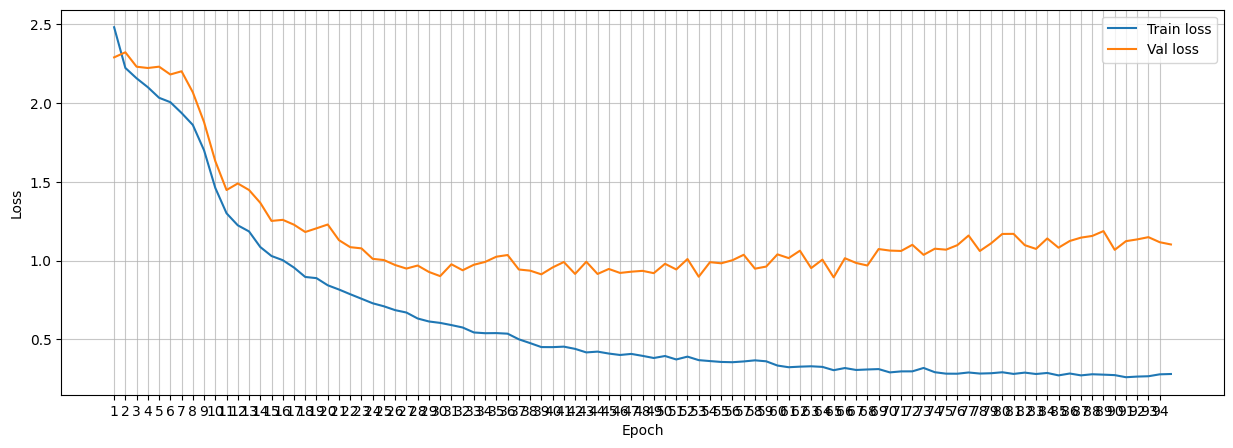

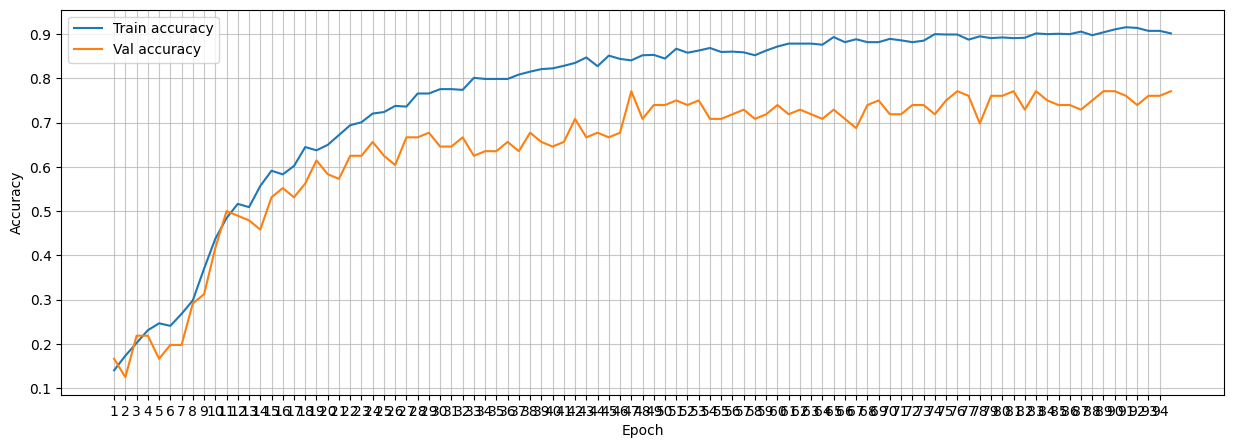

In [40]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6500 (65.00%)

MACRO AVERAGES:
  F1-Score   : 0.6543
  Precision  : 0.6936
  Recall     : 0.6500

WEIGHTED AVERAGES:
  F1-Score   : 0.6543
  Precision  : 0.6936
  Recall     : 0.6500

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.7143   0.8333     0.6250  
clock_tick      0.4615   0.6000     0.3750  
crackling_fire  0.7500   0.7500     0.7500  
crying_baby     0.9412   0.8889     1.0000  
dog             0.7000   0.5833     0.8750  
helicopter      0.4286   0.5000     0.3750  
rain            0.4211   0.3636     0.5000  
rooster         0.8571   1.0000     0.7500  
sea_waves       0.5000   0.4167     0.6250  
sneezing        0.7692   1.0000     0.6250  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.8333    0.6250    0.7143 

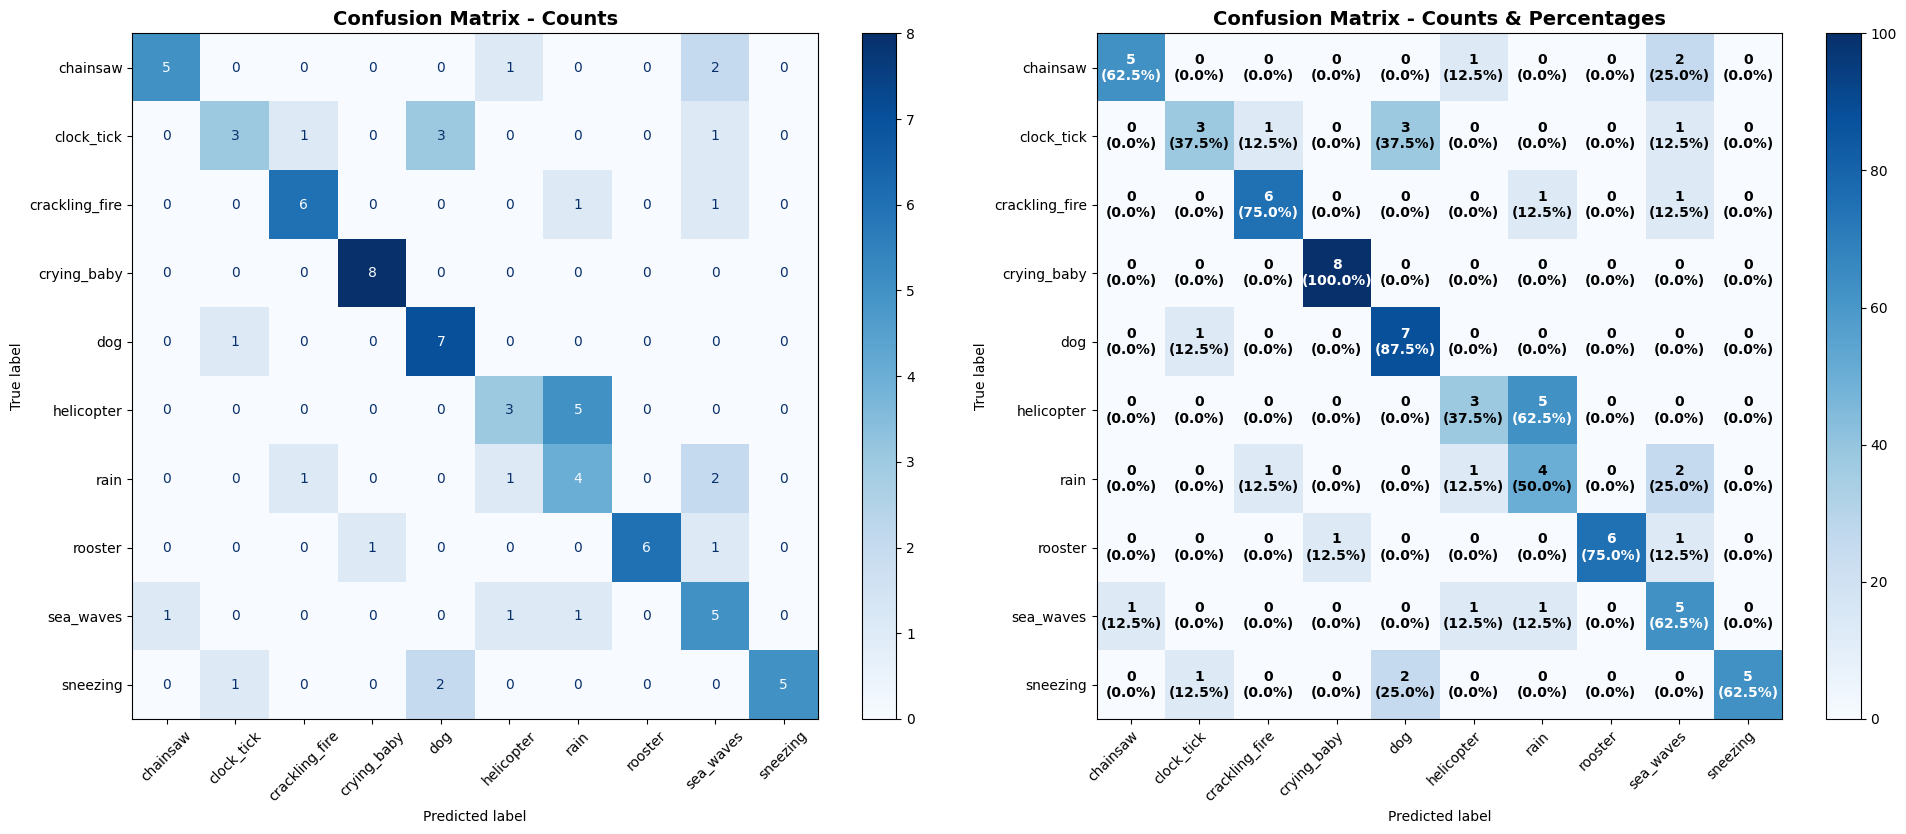


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        5        8        62.50     %
clock_tick      3        8        37.50     %
crackling_fire  6        8        75.00     %
crying_baby     8        8        100.00    %
dog             7        8        87.50     %
helicopter      3        8        37.50     %
rain            4        8        50.00     %
rooster         6        8        75.00     %
sea_waves       5        8        62.50     %
sneezing        5        8        62.50     %


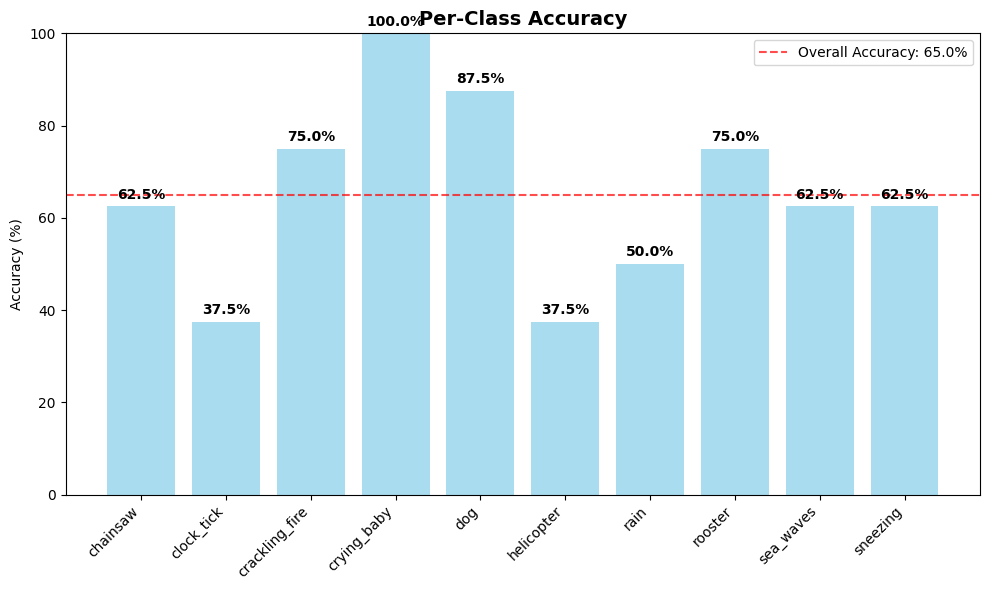

In [41]:
results_scnn_delta = evaluate_model_comprehensive(delta_c_snn_model, delta_test_loader, ESCLabels.class_names, device)

# Spike Encoding: Threshold Adaptive Encoding

In [ ]:
ALPHA = 0.999

In [ ]:
tae_train_dataset = ThresholdAdaptiveDataset(X_train_tensor, y_train_tensor, alpha=ALPHA)
tae_val_dataset = ThresholdAdaptiveDataset(X_val_tensor, y_val_tensor, alpha=ALPHA)
tae_test_dataset = ThresholdAdaptiveDataset(X_test_tensor, y_test_tensor, alpha=ALPHA)

In [ ]:
tae_train_loader = DataLoader(tae_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
tae_val_loader = DataLoader(tae_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
tae_test_loader = DataLoader(tae_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())

In [ ]:
tae_X_batch, tae_y_batch = next(iter(tae_train_loader))
print("Threshold Adaptive encoding compleated!")

In [ ]:
sample_idx = 10
visualize_spike_trains(tae_X_batch, sample_idx=sample_idx, mel_bin=10)
print(f"TAE Class: {ESCLabels(tae_y_batch[sample_idx].item()).name}")

##TAE: SNN training

In [ ]:
tae_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(tae_snn_classifier, input_size=(32, 1, N_MELS))

In [ ]:
optimizer = torch.optim.Adam(tae_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=tae_snn_classifier,
    train_loader=tae_train_loader,
    valid_loader=tae_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
torch.save(tae_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/tae/tae_snn.pth')

##TAE: SNN evaluation

In [ ]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_snn_tae = evaluate_model_comprehensive(tae_snn_classifier, tae_test_loader, ESCLabels.class_names, device)

##TAE: SCNN training

In [ ]:
tae_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(tae_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

In [ ]:
optimizer = torch.optim.Adam(tae_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=tae_c_snn_model,
    train_loader=tae_train_loader,
    valid_loader=tae_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
torch.save(tae_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/tae/tae_scnn.pth')

##TAE: SCNN evaluation

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_scnn_tae = evaluate_model_comprehensive(tae_c_snn_model, tae_test_loader, ESCLabels.class_names, device)

#Spike Encoding: Step Forward

In [ ]:
sf_train_dataset = StepForwardDataset(X_train_tensor, y_train_tensor)
sf_val_dataset = StepForwardDataset(X_val_tensor, y_val_tensor)
sf_test_dataset = StepForwardDataset(X_test_tensor, y_test_tensor)

In [ ]:
sf_train_loader = DataLoader(sf_train_dataset,batch_size=BATCH_SIZE,shuffle=True,
                             num_workers=2,pin_memory=torch.cuda.is_available())

sf_val_loader = DataLoader(sf_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=2, pin_memory=torch.cuda.is_available())

sf_test_loader = DataLoader(sf_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, pin_memory=torch.cuda.is_available())

In [ ]:
sf_X_batch, sf_y_batch = next(iter(sf_train_loader))
print("Threshold Adaptive encoding compleated!")

##Step Forward: SNN training

In [ ]:
sf_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(sf_snn_classifier, input_size=(32, 1, N_MELS))

In [ ]:
optimizer = torch.optim.Adam(sf_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=sf_snn_classifier,
    train_loader=sf_train_loader,
    valid_loader=sf_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
torch.save(sf_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/step_forward/sf_snn.pth')

##Step Forward: SNN evaluation

In [ ]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_snn_sf = evaluate_model_comprehensive(sf_snn_classifier, sf_test_loader, ESCLabels.class_names, device)

##Step Forward: SCNN training

In [ ]:
sf_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(sf_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

In [ ]:
optimizer = torch.optim.Adam(sf_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=sf_c_snn_model,
    train_loader=sf_train_loader,
    valid_loader=sf_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
torch.save(sf_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/step_forward/sf_scnn.pth')

##Step Forward: SCNN evaluation

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_scnn_sf = evaluate_model_comprehensive(sf_c_snn_model, sf_test_loader, ESCLabels.class_names, device)

# Performance Analysis

### Delta Modulation SNN

In [ ]:
analysis_delta_snn = run_performance_evaluation(
    model=delta_snn_classifier,
    train_loader=delta_train_loader,
    val_loader=delta_val_loader,
    test_loader=delta_test_loader,
    device=device
)

###Delta Modulation SCNN

In [ ]:
analysis_delta_scnn = run_performance_evaluation(
    model=delta_c_snn_model,
    train_loader=delta_train_loader,
    val_loader=delta_val_loader,
    test_loader=delta_test_loader,
    device=device
)

###TAE SNN

In [ ]:
analysis_tae_snn = run_performance_evaluation(
    model=tae_snn_classifier,
    train_loader=tae_train_loader,
    val_loader=tae_val_loader,
    test_loader=tae_test_loader,
    device=device
)

###TAE SCNN

In [ ]:
analysis_tae_scnn = run_performance_evaluation(
    model=tae_c_snn_model,
    train_loader=tae_train_loader,
    val_loader=tae_val_loader,
    test_loader=tae_test_loader,
    device=device
)

###Step Forward SNN

In [ ]:
analysis_sf_snn = run_performance_evaluation(
    model=sf_snn_classifier,
    train_loader=sf_train_loader,
    val_loader=sf_val_loader,
    test_loader=sf_test_loader,
    device=device
)

###Step Forward SCNN

In [ ]:
analysis_sf_scnn = run_performance_evaluation(
    model=sf_c_snn_model,
    train_loader=sf_train_loader,
    val_loader=sf_val_loader,
    test_loader=sf_test_loader,
    device=device
)